## Historical fMRI QA Data 2013-2015

The fMRI Stability scans at BCH are based on the fBIRN protocols, which are an adaptation of the published methods of [Friedman and Glover 2006](http://www.ncbi.nlm.nih.gov/pubmed/16649196).
The routine analysis uses the BIRN code and the scans are of a spherical phantom based on that used by BIRN.
The BIRN software and protocols are available at:

- [BIRN](http://www.birncommunity.org/tools-catalog/function-birn-stability-phantom-qa-procedures/)
- [New BHX Xcede Tools](http://www.nitrc.org/projects/bxh_xcede_tools)
- [BHX Tools Docs](https://xwiki.nbirn.org:8443/bin/view/Function-BIRN/AutomatedQA)

This notebook is a longitudinal survey of the summary results obtained using the fBIRN software.

Individual QA analysis results are saved in a database indexed by the date of the acquisition and this historical data used to generate the plots below.

In [1]:
from __future__ import division, print_function

from IPython.core.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

import numpy as np

In [2]:
import psycopg2
import datetime as dt

def fetch_qa_history_pg(field, start_date, end_date):
    '''The given parameter from the postgres database over the given date range. The parameter is specified as one of list of strings
       below which are the column names in the database. The dates specifying the range are strings in ISO YYYY-mm-dd form.
       Returns a tuple of lists. The first element is a list of dates
       as python datetime objects and the second is the recorded values of the parameter.
    '''

    # Database details
    DBNAME    = 'fMRIQAResults'
    DBHOST    = 'canopus'
    TABLENAME = 'qaaladdin'

    # The fields that are tracked - only accept one of these
    FIELDS = [
        "percentFluc", "drift",     "driftfit",
        "mean",        "SNR",       "SFNR",
        "rdc",         "std",
        "minFWHMX",    "meanFWHMX", "maxFWHMX",
        "minFWHMY",    "meanFWHMY", "maxFWHMY",
        "minFWHMZ",    "meanFWHMZ", "maxFWHMZ",
        "dispCMassX",  "driftCMassX",
        "dispCMassY",  "driftCMassY",
        "dispCMassZ",  "driftCMassZ",
        "meanGhost",   "meanBrightGhost",
        "scandate",    "operator",
        "tskip",       "zpos"    ,  "roisize"
    ]
    assert field in FIELDS

    # db wants datetime objects in query
    dates = [dt.datetime.strptime(s, '%Y-%m-%d') for s in (start_date, end_date)]
    assert dates[1] >= dates[0]

    connection = psycopg2.connect(database=DBNAME, host=DBHOST)
    
    cursor = connection.cursor()
    query = 'SELECT scandate, %s FROM ' % field + TABLENAME + ' WHERE scandate >= %s AND scandate <= %s'
    cursor.execute(query, dates)
    results = list(cursor.fetchall())
    cursor.close()
    
    connection.close()
    
    return zip(*results)


We extract the data from the QA database for the time period of interest.

In [3]:
start_date, end_date = ['2014-01-01', '2015-05-01']

### The Signal to Fluctuation Noise Ratio and raw SNR

This plots the ordinary SNR within a region of interest obtained by subtraction of consecutive frames and the Signal to Fluctuation Noise ratio in which the noise is calculated as the standard deviation of the detrended signal time course. We expect the SFNR to be somewhat less than the SNR and that this additional noise will be approximately multiplicative as it arises from gain fluctuations. A few values for the SNR are missing where the fBIRN routines encountered an overflow at some time point. A slight improvement is apparent over the year but without further datapoint it is not clear whether this is signifiacnt.

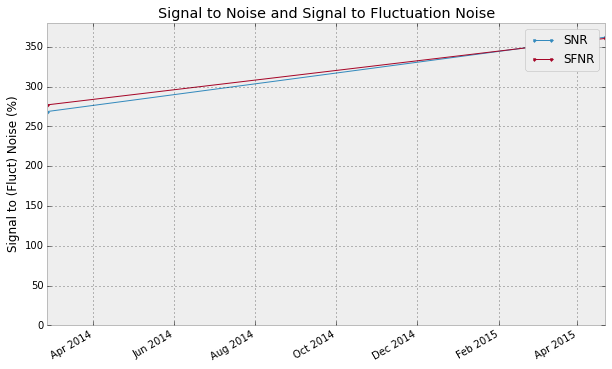

In [4]:
# The Signal to Fluctuation noise and the raw SNR compared
dates, snr = fetch_qa_history_pg('SNR', start_date, end_date)
dates, sfnr = fetch_qa_history_pg('SFNR', start_date, end_date)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fig.autofmt_xdate()
ax.plot_date(dates, snr, fmt='.-',  label='SNR')
ax.plot_date(dates, sfnr, fmt='.-', label='SFNR')

ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_title('Signal to Noise and Signal to Fluctuation Noise')
ax.set_ylabel('Signal to (Fluct) Noise (%)')
ax.legend();

### The Drift and Fluctuation in Signal

Here we plot the raw drift and fluctuation values. The drift is the slow gain variation that would typically be taken out by linear or quadradtic detrending. After quadrating detrending the remaining variablity is termed the fluctuation. There is an increase in drift since the last measurement but it is still below 1%. 

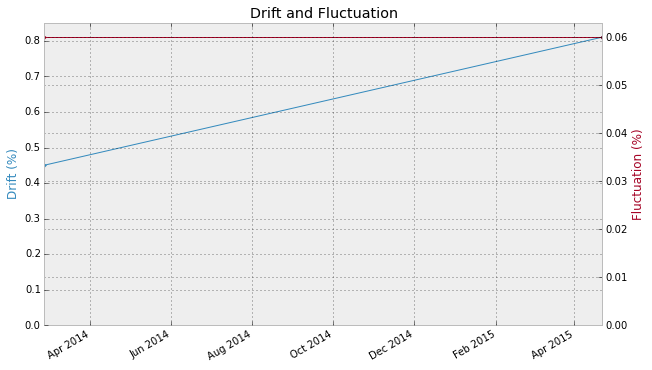

In [5]:
# The longterm drift and fluctuations in Signal
dates, fluct = fetch_qa_history_pg('percentFluc', start_date, end_date)
dates, drift = fetch_qa_history_pg('drift', start_date, end_date)

from mpl_toolkits.axes_grid1 import host_subplot
plt.figure(figsize=(10, 6))
host = host_subplot(111)
par = host.twinx()

plt.gcf().autofmt_xdate()

p1, = host.plot_date(dates, drift,  fmt='.-', label='Drift')
host.set_ylabel('Drift (%)')

p2, = par.plot_date(dates, fluct,  fmt='.-',  label='Fluct.')
par.set_ylabel('Fluctuation (%)')

host.set_ylim(bottom=0)
par.set_ylim(bottom=0)
host.set_title('Drift and Fluctuation')

host.yaxis.get_label().set_color(p1.get_color())
par.yaxis.get_label().set_color(p2.get_color())
host.xaxis.grid(True);

### Nyquist Ghosting

Echo planar images are particularly liable to ghosting artefacts. These typically occur at a displacement of half the field of view in the phase encoding direction and are due to small echo position misalignments under the alternating readout gradient. The *average* intensity of these ghosts is plotted here. In addition fBIRN calculate the avarage intensity of the brightest ghosts (the brightest 10% of pixels in the ghosting areas). This is intended as an indication of the *maximum* ghost intensity. The level of ghosting on this scanner is somewhat lower than the CRIC Skyra and has remained unchanged or slightly improved from last year.

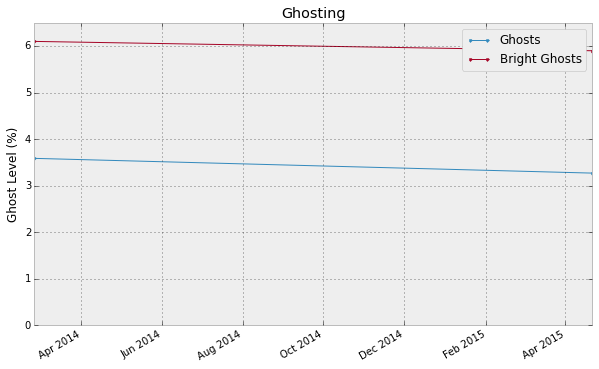

In [6]:
# The average and 'worst' level of Nyquist ghosting

dates, ghosts = fetch_qa_history_pg('meanGhost', start_date, end_date)
dates, brightghosts = fetch_qa_history_pg('meanBrightGhost', start_date, end_date)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fig.autofmt_xdate()
ax.plot_date(dates, ghosts, fmt='.-',  label='Ghosts')
ax.plot_date(dates, brightghosts, fmt='.-', label='Bright Ghosts')

ax.set_ylim(bottom=0)
ax.set_title('Ghosting')

ax.set_ylabel('Ghost Level (%)')
ax.legend()
ax.grid(True);

### Image Smoothness(FWHM)

This analysis uses the [Afni](http://afni.nimh.nih.gov/afni/ Afni) tool `3dFWHM` which determines how the image smoothness varies along the time series.

The method is based on Gaussian Random Field Theory. There are details of the theory here:

1. [Jenkinson FMRIB Tech Rep TR00MJ3](http://www.fmrib.ox.ac.uk/analysis/techrep/tr00mj3/tr00mj3/)
2. [Forman et al, MRM 33:636-647, 1995](http://onlinelibrary.wiley.com/doi/10.1002/mrm.1910330508/abstract)

The solid line shows the average smoothness along the 20 minute time series and the filled area the variability over the scan.

There has been a slight increase in the variability of the smoothness, especially in the Z dircetion. This is likely due to the transient in the first minute or two of scanning.

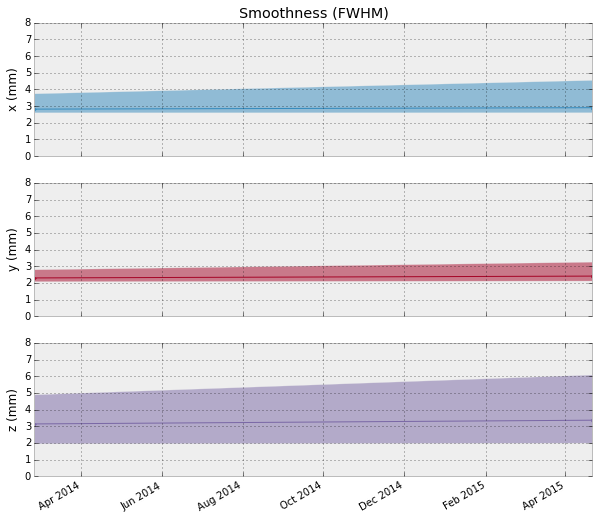

In [7]:
# The image smoothness along each axis, shows the average and the range over the scan time for each date

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=True, figsize=(10,9))
fig.autofmt_xdate()

dates, minfwhmx  = fetch_qa_history_pg("minFWHMX",  start_date, end_date)
dates, meanfwhmx = fetch_qa_history_pg("meanFWHMX", start_date, end_date)
dates, maxfwhmx  = fetch_qa_history_pg("maxFWHMX",  start_date, end_date)

ax = axs[0]
line, = ax.plot_date(dates, meanfwhmx, '.-')
ax.fill_between(dates, minfwhmx, maxfwhmx, facecolor=line.get_color(), alpha=0.5)
ax.set_ylim(bottom=0)
ax.set_ylabel('x (mm)')
ax.set_title('Smoothness (FWHM)')
ax.grid(True)
ax.set_ylim([0, 8])
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

dates, minfwhmy  = fetch_qa_history_pg("minFWHMY",  start_date, end_date)
dates, meanfwhmy = fetch_qa_history_pg("meanFWHMY", start_date, end_date)
dates, maxfwhmy  = fetch_qa_history_pg("maxFWHMY",  start_date, end_date)

ax = axs[1]
next(ax._get_lines.color_cycle)
line, = ax.plot_date(dates, meanfwhmy, fmt='.-')
ax.fill_between(dates, minfwhmy, maxfwhmy, facecolor=line.get_color(), alpha=0.5)
ax.set_ylim(bottom=0)
ax.set_ylabel('y (mm)')
ax.grid(True)
ax.set_ylim([0, 8])
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

dates, minfwhmz  = fetch_qa_history_pg("minFWHMZ",  start_date, end_date)
dates, meanfwhmz = fetch_qa_history_pg("meanFWHMZ", start_date, end_date)
dates, maxfwhmz  = fetch_qa_history_pg("maxFWHMZ",  start_date, end_date)

ax = axs[2]
next(ax._get_lines.color_cycle)
next(ax._get_lines.color_cycle)
line, = ax.plot_date(dates, meanfwhmz, fmt='.-')
ax.fill_between(dates, minfwhmz, maxfwhmz, facecolor=line.get_color(), alpha=0.5)
ax.set_ylim(bottom=0)
ax.set_ylabel('z (mm)')
ax.grid(True)
ax.set_ylim([0, 8])
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'));

### Image Positional Stability

This is done by determining the position of the spherical phantom in three coordinates at each time point and taking the drift and the maximum displacement over time. The variability here is usually very small.

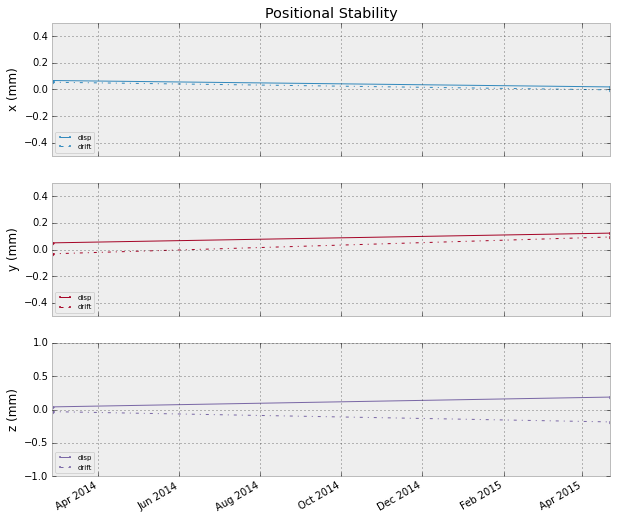

In [8]:
# Positional drift during scan in mm, both the long term drift and the maximum displacement are plotted
from matplotlib.font_manager import FontProperties
fontprops = FontProperties()
fontprops.set_size('x-small')

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=True, figsize=(10,9))
fig.autofmt_xdate()

dates, dispx  = fetch_qa_history_pg("dispCMassX",  start_date, end_date)
dates, driftx = fetch_qa_history_pg("driftCMassX", start_date, end_date)

ax = axs[0]
line, = ax.plot_date(dates, dispx, fmt='.-', label='disp')
ax.plot_date(dates, driftx, fmt='.-.', color=line.get_color(), label='drift')
ax.set_ylim(bottom=0)
ax.set_ylabel('x (mm)')
ax.set_title('Positional Stability')
ax.grid(True)
ax.set_ylim([-0.5, 0.5])
ax.legend(loc='lower left', markerscale=0.5, fancybox=True, prop=fontprops)

dates, dispy  = fetch_qa_history_pg("dispCMassY",  start_date, end_date)
dates, drifty = fetch_qa_history_pg("driftCMassY", start_date, end_date)

ax = axs[1]
next(ax._get_lines.color_cycle)
line, = ax.plot_date(dates, dispy, fmt='.-', label='disp')
ax.plot_date(dates, drifty, fmt='.-.', color=line.get_color(), label='drift')
ax.set_ylim(bottom=0)
ax.set_ylabel('y (mm)')
ax.grid(True)
ax.set_ylim([-0.5, 0.5])
ax.legend(loc='lower left', markerscale=0.5, fancybox=True, prop=fontprops)

dates, dispz = fetch_qa_history_pg("dispCMassZ",  start_date, end_date)
dates, driftz = fetch_qa_history_pg("driftCMassZ", start_date, end_date)

ax = axs[2]
next(ax._get_lines.color_cycle)
next(ax._get_lines.color_cycle)
line, = ax.plot_date(dates, dispz, fmt='.-', label='disp')
ax.plot_date(dates, driftz, fmt='.-.', color=line.get_color(), label='drift')
ax.set_ylim(bottom=0)
ax.set_ylabel('z (mm)')
ax.grid(True)
ax.set_ylim([-1, 1])
ax.legend(loc='lower left', markerscale=0.5, fancybox=True, prop=fontprops);

### Weisskoff Summary

The Weissskoff analysis takes the time series of the average signal intensity within ROIs for a range of different ROI sizes and plots (on a log-log scale) the Coefficient of Variation (normalised SD) *wrt* to time against the
size of the ROI in pixels. The expected relation in the absence of additional correlations is $1/n$ so in the absence of system instabilities the points should follow a straight line of slope -1 on the log-log plot. However, system instabilities tend to lead to a plateau above a certain size ROI.


fBIRN also define a a single number - the *Radius of Decorrelation* to characterise the curve:

$$R_{DC} = \frac{CV_{1}}{CV_{N_{max}}}$$

The historical values of this are plotted here. 

Most of the detailed results of the Weisskoff analysis to date at CRIC show rather erratic behaviour and do not follow the expected curve so the significance of the variations in the ROD plotted here is unclear.

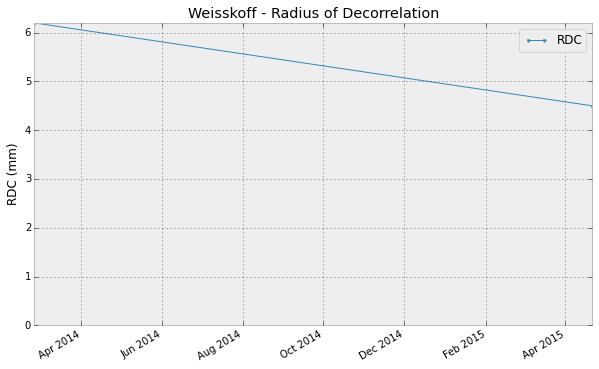

In [9]:
#
# Radius of decorrelation in Weisskoff plot
#

dates, rdc = fetch_qa_history_pg('rdc', start_date, end_date)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fig.autofmt_xdate()
ax.plot_date(dates, rdc, fmt='.-',  label='RDC')

ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_title('Weisskoff - Radius of Decorrelation')
ax.set_ylabel('RDC (mm)')
ax.legend();

### Field Drift and Transmitter Drift

We can plot the history of system calibrations by obtaining the first slice from each QA run and extracting the data from the Siemens shadow data tags. Here we plot the system frequency and the calibrated transmitter voltage.

In [10]:
# Interface to query DICOM server for images
import dicom as dcm
from dcmfetch.queryinterface import QueryInterface, QIError
from dcmfetch.aettable import AetTable

import os
from datetime import datetime
from platform import node

# Details of CRIC's DICOM Server
DFLT_LOCAL_AET = node().split('.')[0] + 'Store'
aetable = AetTable('./dcmnodes.cf') if os.path.exists('./dcmnodes.cf') else AetTable('/etc/dcmnodes.cf')
qi = QueryInterface(aetable, DFLT_LOCAL_AET)
server = 'Dcm4Chee'

In [11]:
# Get one frame from the 20 minute protocol of each of the runs
from operator import attrgetter
matching_patients = sorted(qi.pat_level_find(server, '*', '*QA*', '*', '*'), key=attrgetter('patid'))
seriess = []
for patid in [pat.patid for pat in matching_patients]:
    seriess += qi.combo_find(server, patid)
    
# Series in date order
seriess.sort(key=lambda s: s.studydate)
seriess = filter(lambda s: s.description == 'ep2d_fbirn_20min', seriess)

# Get image uids for first (could be any) frame
images = []
for series in seriess:
    images += qi.image_level_find(server, patid=series.patid, studyuid=series.studyuid, seriesuid=series.seriesuid)[:1]

In [12]:
# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
from glob import glob
from os.path import join as pjoin
tempdir = mkdtemp()

for (series, image) in zip(seriess, images):
    # NB Returns a generator hence list() to force iteration
    list(qi.image_level_fetch(server,
                          patid=series.patid, studyuid=series.studyuid, seriesuid=series.seriesuid, imageuid=image.imageuid,
                          savedir=tempdir))

dicom_series = sorted([
    dcm.read_file(f) for f in glob(pjoin(tempdir, '*'))
], key=lambda d: d.AcquisitionDate if 'AcquisitionDate' in d else d.SeriesDate)

# Unfortunately this restriction can't be done in the query 
station_name = 'ALADDIN'
dicom_series = filter(lambda d: d.StationName == station_name, dicom_series)

rmtree(tempdir)

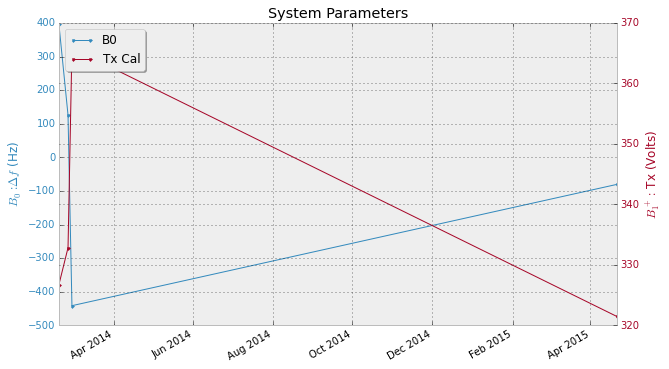

In [13]:
# Plot system data obtained from shadow headers etc
from dcmextras.siemenscsa import csa, phoenix

# Centre frequency
freqs = np.asarray([float(d.ImagingFrequency) for d in dicom_series]) * 1000000

# Transmitter voltages
cal_voltages = np.asarray([float(csa(d)['TransmitterCalibration']) for d in dicom_series])
fl_voltages = np.asarray([float(phoenix(d)['sTXSPEC.aRFPULSE[0].flAmplitude']) for d in dicom_series])

# The voltage of the excitation pulse is a fixed ratio of the reference voltage
#print 'Excitation: Reference =', set(around(fl_voltages/cal_voltages, 5))
dates = [datetime.strptime(d.AcquisitionDate, '%Y%m%d') for d in dicom_series]

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
l1 = ax1.plot_date(dates, freqs - np.mean(freqs), fmt='.-')
ax1.grid(True)
ax1.set_ylabel(r'$B_0: \Delta f$ (Hz)', color=l1[0].get_color())
for tl in ax1.get_yticklabels():
    tl.set_color(l1[0].get_color())
fig.autofmt_xdate()

ax2 = ax1.twinx()
next(ax2._get_lines.color_cycle)
l2 = ax2.plot(dates, cal_voltages, '.-')

ax2.set_ylabel(r'$B_1^+:$ Tx (Volts)', color=l2[0].get_color())
for tl in ax2.get_yticklabels():
    tl.set_color(l2[0].get_color())
plt.legend(l1 + l2, ['B0', 'Tx Cal'], shadow=True, fancybox=True, loc=2)
plt.title('System Parameters');

There are some changes here but there are insufficient data points to indicate a trend. The initial two point are from the scans before the gradient cooling problem was fixed.